# Investigation of Hawaii Airbnb Data Following CRISP-DM Process - Part 2

Continued from Part-1 notebook, The CRISP-DM Process (Cross Industry Process for Data Mining) of the following stpes will be showcased here; 
- Business understanding -> Data understanding -> Data preparation -> Data modeling -> Results evaluation.

## Table of Contents
<ul>
<li><a href="#Business understanding">Business understanding</a></li>
<li><a href="#Data understanding">Data understanding</a></li>
<li><a href="#Data preparation">Data preparation</a></li>
<li><a href="#Data modeling">Data modeling</a></li>
<li><a href="#Results evaluation">Results evaluation</a></li>
</ul>

<a id='Business understanding'></a>
# Business understanding

In the Part-1 notebook (hawaii_airbnb_q1_q2_part1.ipynb), I analyzed Hawaii Airbnb data from a guest point of view to plan my first big family vacation to Hawaii.
In this Part-2 notebook, the analyses will be performed for a potential host who plans to launch a new accommodation in Hawaii. While many properties that are currently listed on Airbnb can be used as a reference for pricing, there is no reliable way for new hosts to set the price for their listings. Here, a predictive model for prices of Hawaii Airbnb is developed and the factors that affect the prices are investigated. The results are expected to help new hosts set competitive prices for their properties.  
  
**Question 3: How to set the price for a new Airbnb property as a new host? What factors affect Airbnb prices in Hawaii?**

<a id='Data understanding'></a>
# Data understanding

Airbnb listings data in Hawaii as of 10 June, 2023 (data source: http://insideairbnb.com/get-the-data/) is used for this analysis. 'listings.csv' and 'calendar.csv' files are used because they contain relevant information to tackle the business questions posed above such as listing prices, date, the maximum capacity, and so on.

<a id='Data preparation'></a>
# Data preparation

## Data wrangling & Exploratory data analysis (EDA)

In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# load the data set
df_listing = pd.read_csv('listings.csv')

In [2]:
# initial screenung of predictor variables from the original data set
df_listing.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

Columns of 'host_is_superhost', 'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'number_of_reviews', 'review_scores_rating' are selected based on the relevance to prices.

The descriptions of each column can be found here (https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=1322284596).

In [3]:
# make a new dataframe, df_listing_clean, only with the selected columns
selected_cols = ['host_is_superhost', 'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',\
                 'bathrooms_text', 'bedrooms', 'beds', 'number_of_reviews', 'review_scores_rating', 'price']
df_listing_clean = df_listing[selected_cols].copy()
df_listing_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32597 entries, 0 to 32596
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_is_superhost       30879 non-null  object 
 1   neighbourhood_cleansed  32597 non-null  object 
 2   property_type           32597 non-null  object 
 3   room_type               32597 non-null  object 
 4   accommodates            32597 non-null  int64  
 5   bathrooms_text          32585 non-null  object 
 6   bedrooms                26986 non-null  float64
 7   beds                    32148 non-null  float64
 8   number_of_reviews       32597 non-null  int64  
 9   review_scores_rating    24919 non-null  float64
 10  price                   32597 non-null  object 
dtypes: float64(3), int64(2), object(6)
memory usage: 2.7+ MB


### Change the data types

It seems that the data types of 'bathrooms_text' and 'price' columns need to be checked.

#### bathrooms_text

In [4]:
df_listing_clean.bathrooms_text.unique()

array(['1 bath', '2.5 baths', '3 baths', '1 shared bath',
       '1 private bath', '2 baths', '1.5 baths', '4 baths',
       '1.5 shared baths', '3.5 shared baths', '3.5 baths',
       '2 shared baths', '4.5 baths', '0 baths', '0 shared baths',
       'Half-bath', '5.5 baths', '5 baths', '8 baths', '3 shared baths',
       '6.5 baths', nan, '7.5 baths', '6.5 shared baths', '7 baths',
       'Shared half-bath', '6 baths', '4 shared baths', '10 baths',
       '2.5 shared baths', '8.5 baths', '10 shared baths', '9.5 baths',
       '14 baths', 'Private half-bath', '9 baths', '12 baths',
       '4.5 shared baths', '17 baths', '11 baths', '13 baths',
       '10.5 baths', '22 baths'], dtype=object)

In [5]:
# change the words to floats to unify the format of the column
# Half-bath, Shared half-bath, Private half-bath -> 0.5 baths
# Replace multiple specific strings in 'column_name' with other strings
replace_dict_bathrooms = {'Half-bath': '0.5 baths', 'Shared half-bath': '0.5 baths', 'Private half-bath': '0.5 baths'}
df_listing_clean['bathrooms_text'] = df_listing_clean['bathrooms_text'].replace(replace_dict_bathrooms)

In [6]:
# take the first number part
df_listing_clean['bathrooms_text'] = df_listing_clean['bathrooms_text'].str.split().str[0]

In [7]:
# change the data type to float
df_listing_clean['bathrooms_text'] = df_listing_clean['bathrooms_text'].astype('float64')

In [8]:
# change the column name
df_listing_clean = df_listing_clean.rename(columns={'bathrooms_text':'bathrooms'})

#### price

In [9]:
df_listing_clean.price.unique()

array(['$250.00 ', '$119.00 ', '$117.00 ', ..., '$7,420.00 ',
       '$1,822.00 ', '$1,048.00 '], dtype=object)

In [10]:
# take comma and $ sign out from price column
df_listing_clean['price'] = df_listing_clean['price'].str.replace(',','').str.replace('$','')

d:\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [11]:
# # change the data type to float
df_listing_clean['price'] = df_listing_clean['price'].astype('float64')

### Examination of each column

In [12]:
# check the number of unique values (categorical) and missing values
def examine_df_column(df, col):
    """Print histogram(quantitative) / the number of unique values(categorical) and missing values in a single column 
    Args:
    df - pandas dataframe
    col - a column in dataframe to check
    
    Returns:
    histogram - distribution of the quantitative data
    # of unique values - the number of unique values of categorical data
    # of missing values   
    """
    print('information on', col, 'column')
    
    if df[col].dtypes == 'O':
        print('# of unique values =', df[col].nunique())
    elif df[col].dtypes == 'int64' or 'float64':
        df[col].hist()
        plt.show()
    
    print('# of missing values=', df[col].isna().sum(), ', percentage(%):', '{:.1f}'.format(df[col].isna().sum()/len(df)*100))

information on host_is_superhost column
# of unique values = 2
# of missing values= 1718 , percentage(%): 5.3
information on neighbourhood_cleansed column
# of unique values = 30
# of missing values= 0 , percentage(%): 0.0
information on property_type column
# of unique values = 90
# of missing values= 0 , percentage(%): 0.0
information on room_type column
# of unique values = 4
# of missing values= 0 , percentage(%): 0.0
information on accommodates column


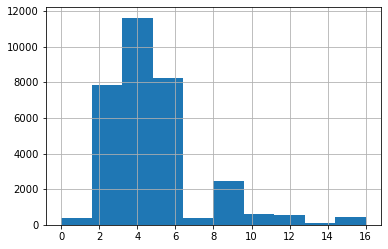

# of missing values= 0 , percentage(%): 0.0
information on bathrooms column


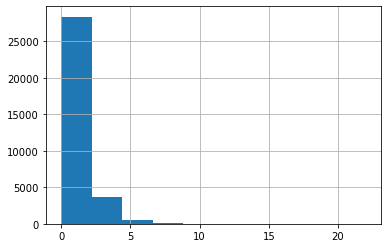

# of missing values= 12 , percentage(%): 0.0
information on bedrooms column


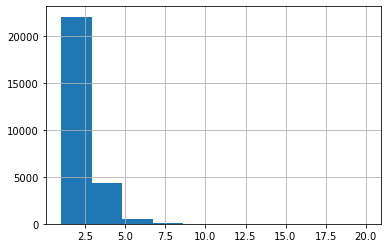

# of missing values= 5611 , percentage(%): 17.2
information on beds column


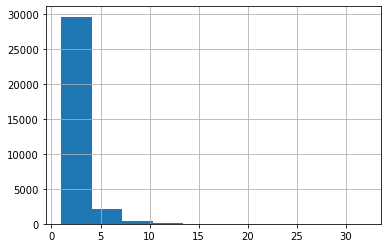

# of missing values= 449 , percentage(%): 1.4
information on number_of_reviews column


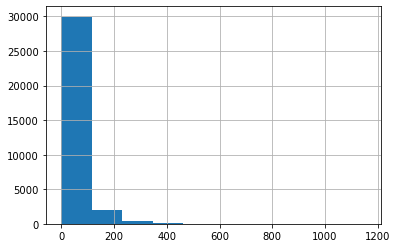

# of missing values= 0 , percentage(%): 0.0
information on review_scores_rating column


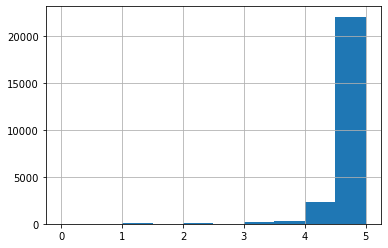

# of missing values= 7678 , percentage(%): 23.6
information on price column


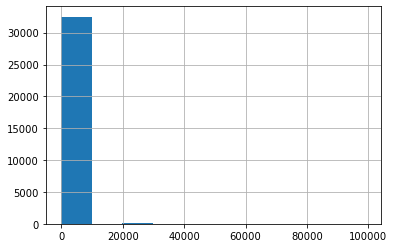

# of missing values= 0 , percentage(%): 0.0


In [13]:
# exmaine each column
for col in df_listing_clean.columns:
    examine_df_column(df_listing_clean, col)

### Manual treatment for outliers

From the histograms above, some outlier data points can be treated manually before proceeding to modeling systematically.  
It seems outliers are found in the columns of bathrooms, bedrooms, and price.

#### bathrooms

In [14]:
# check the data points where the number of bathrooms is larger than 10
df_listing_clean.query('bathrooms > 10')

,host_is_superhost,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,price
7594,NaN,South Kohala,Entire villa,Entire home/apt,16,14.0,10.0,16.0,1,5.0,18500.0
12890,t,Lahaina,Entire villa,Entire home/apt,16,12.0,12.0,16.0,0,NaN,5676.0
13713,f,North Kohala,Room in boutique hotel,Private room,16,17.0,17.0,32.0,0,NaN,3200.0
14716,t,Lahaina,Entire condo,Entire home/apt,16,12.0,12.0,13.0,0,NaN,4426.0
14905,f,Lahaina,Entire home,Entire home/apt,16,11.0,11.0,32.0,10,4.6,4995.0
19512,t,Kihei-Makena,Entire home,Entire home/apt,16,13.0,10.0,16.0,1,4.0,3334.0
22184,NaN,Paia-Haiku,Entire villa,Entire home/apt,16,10.5,9.0,9.0,0,NaN,7500.0
26692,f,Lahaina,Entire condo,Entire home/apt,4,22.0,1.0,2.0,0,NaN,1270.0
29065,NaN,Primary Urban Center,Camper/RV,Entire home/apt,2,12.0,NaN,1.0,1,1.0,36.0
30840,t,Lahaina,Entire condo,Entire home/apt,16,12.0,12.0,13.0,0,NaN,3575.0


All rows with bathrooms > 10 will be removed.

In [15]:
# filter the dataframe with bathrooms <= 10
df_listing_clean = df_listing_clean[~(df_listing_clean['bathrooms'] > 10)]

#### bedrooms

In [16]:
# check the data points where the number of bedrooms is larger than 10
df_listing_clean.query('bedrooms > 10')

,host_is_superhost,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,price
407,f,Koolaupoko,Entire home,Entire home/apt,6,1.5,20.0,5.0,1,5.00,150.0
9673,t,Kihei-Makena,Room in boutique hotel,Hotel room,16,NaN,12.0,12.0,0,NaN,5067.0
9795,f,Koolaupoko,Entire cottage,Entire home/apt,4,1.0,14.0,2.0,8,4.88,412.0
16814,t,Koloa-Poipu,Entire home,Entire home/apt,16,0.0,11.0,16.0,4,5.00,3517.0


All rows with bedrooms > 10 will be removed.

In [17]:
# filter the dataframe with bedrooms <= 10
df_listing_clean = df_listing_clean[~(df_listing_clean['bedrooms'] > 10)]

#### price

In [18]:
df_listing_clean.price.describe()

count    32583.000000
mean       473.425314
std       1395.679234
min          0.000000
25%        163.000000
50%        259.000000
75%        439.000000
max      99110.000000
Name: price, dtype: float64

In the summary above, the minimum price is 0. This row shoud be removed.

In [19]:
# remove the row with price = 0
df_listing_clean = df_listing_clean[~(df_listing_clean['price'] == 0)]

For the purpose of the study (planning on family trip), the properties that are too expensive (or wrong input) are excluded from this study. That is, the rows with $1,500 or higher are eliminated.

In [20]:
# check the data points where price is higher than $1,500
len(df_listing_clean.query('price > 1500'))

1169

In [21]:
# exclude the rows with a daily price of $1,500 or higher
df_listing_clean = df_listing_clean[~(df_listing_clean['price'] > 1500)]

### EDA with cleaned data

In [22]:
df_listing_clean.describe()

,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,price
count,31413.000000,31403.000000,25832.000000,30979.000000,31413.000000,24431.000000,31413.000000
mean,4.592812,1.499697,1.739083,2.469092,34.444848,4.760145,334.591602
std,2.273964,0.809792,0.900652,1.413131,64.033454,0.371970,264.081810
min,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,9.000000
25%,3.000000,1.000000,1.000000,1.000000,1.000000,4.680000,160.000000
50%,4.000000,1.000000,2.000000,2.000000,9.000000,4.860000,250.000000
75%,6.000000,2.000000,2.000000,3.000000,39.000000,5.000000,402.000000
max,16.000000,8.500000,10.000000,22.000000,1154.000000,5.000000,1500.000000


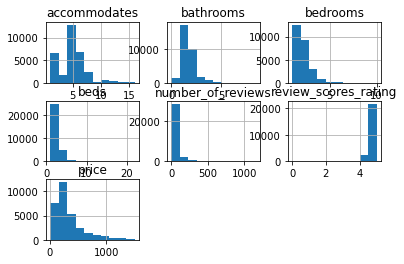

In [23]:
df_listing_clean.hist();

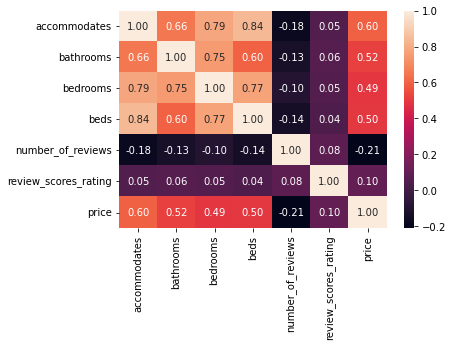

In [24]:
sns.heatmap(df_listing_clean.corr(), annot=True, fmt=".2f");

Strong correlations are found between accommodates, bathrooms, bedrooms, beds, and price.

In [25]:
# draw a scatter plot between two quantitative variables

def draw_scatter_plot(x, y):
    """Draw a scatter plot with two selected columns (quantitative) with a defined figure size
    Args:
    x - string. column name of df_listing_clean for x-axis
    y - string. column name of df_listing_clean for y-axis
    fig_size - list. figure size of the plot
    
    Returns:
    scatter plot
    """
    plt.scatter(data=df_listing_clean, x=x, y=y)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show();

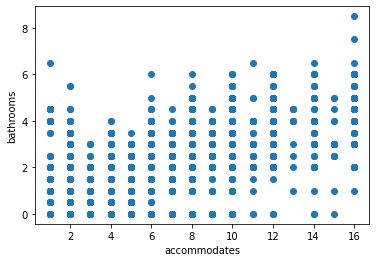

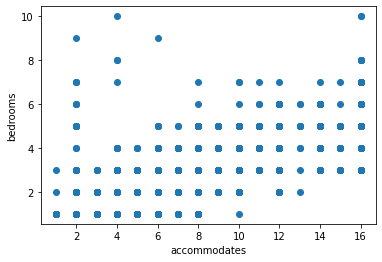

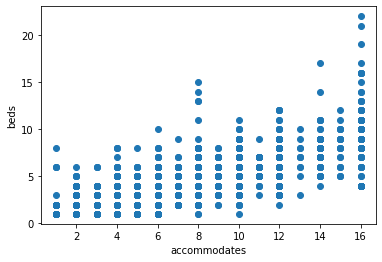

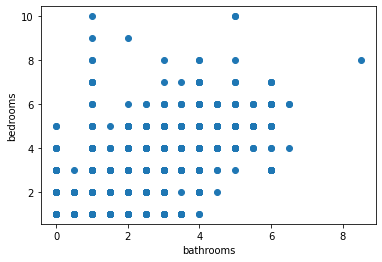

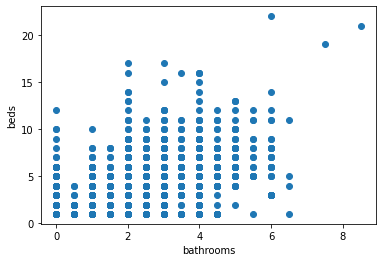

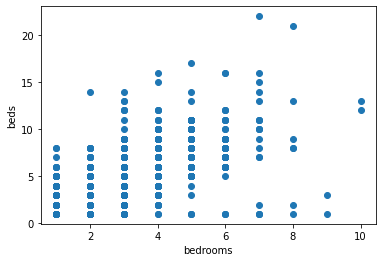

In [26]:
draw_scatter_plot('accommodates','bathrooms') # scatter plots with accommodates and bathrooms
draw_scatter_plot('accommodates','bedrooms')
draw_scatter_plot('accommodates','beds')
draw_scatter_plot('bathrooms','bedrooms')
draw_scatter_plot('bathrooms','beds')
draw_scatter_plot('bedrooms','beds')

In [27]:
# draw a bar chart for categorical variables

def draw_bar_chart(x, fig_size):
    """Draw a bar chart for selected column (categorical) with a defined figure size
    Args:
    x - string. column name of df_listing_clean to draw a plot
    fig_size - list. figure size of the plot
    
    Returns:
    bar chart
    """
    base_color = sns.color_palette()[0]
    plt.figure(figsize=fig_size)
    sns.countplot(data=df_listing_clean, x=x, color=base_color)
    plt.xticks(rotation=90)
    plt.show();

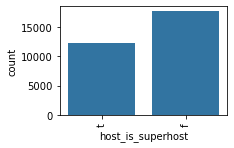

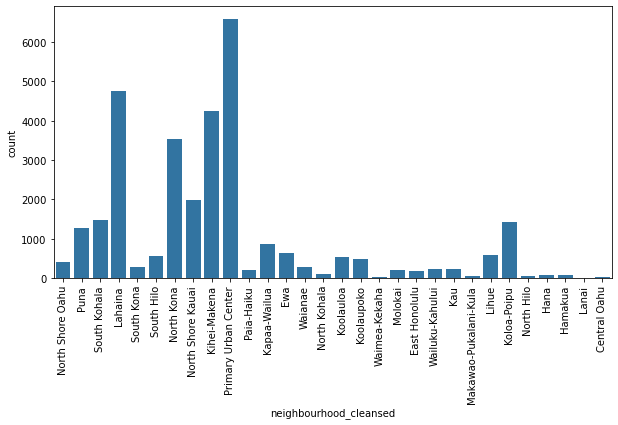

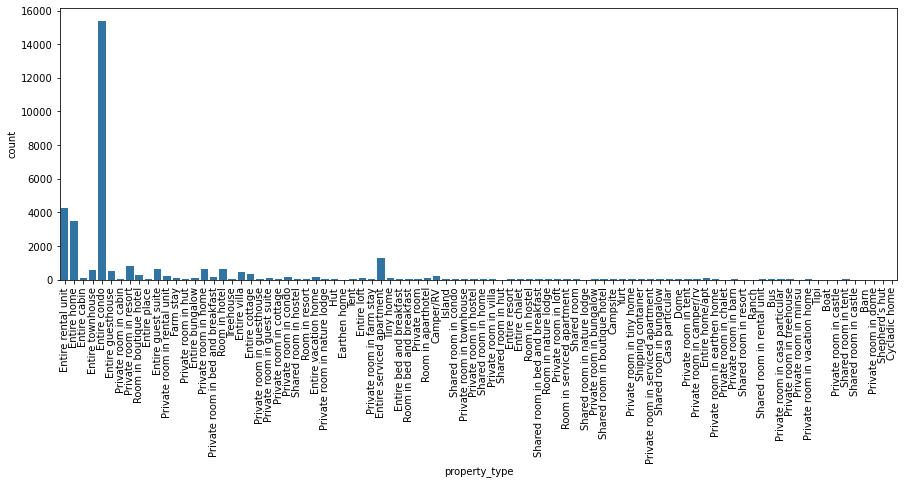

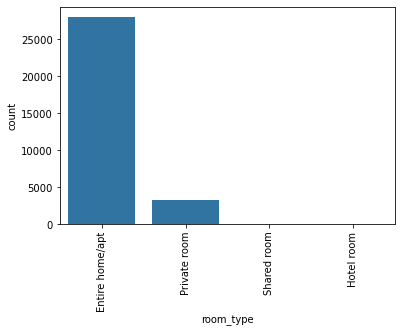

In [28]:
draw_bar_chart('host_is_superhost', [3,2])
draw_bar_chart('neighbourhood_cleansed', [10,5])
draw_bar_chart('property_type', [15,5])
draw_bar_chart('room_type', [6,4])

<a id='Data modeling'></a>
# Data modeling

To efficiently combat multicollinearity among some of the features, a random forest model was chosen for regression. The functions for data pre-processing, feature selection + engineering, model training + testing, and feature importance analysis are loaded from 'Airbnb_Price_ML.py' file.

In [29]:
from Airbnb_Price_ML import *

price_model = ML_regression(df_listing_clean)
price_model.perform_rfr()

<a id='Results evaluation '></a>
# Results evaluation

In [30]:
# metric scores
price_model.error_metrics_dict

{'r2_scores_train': 0.6521512182235443,
 'r2_scores_test': 0.5676947681525447,
 'mae_train': 102.3564900413763,
 'mae_test': 114.09055280045018}

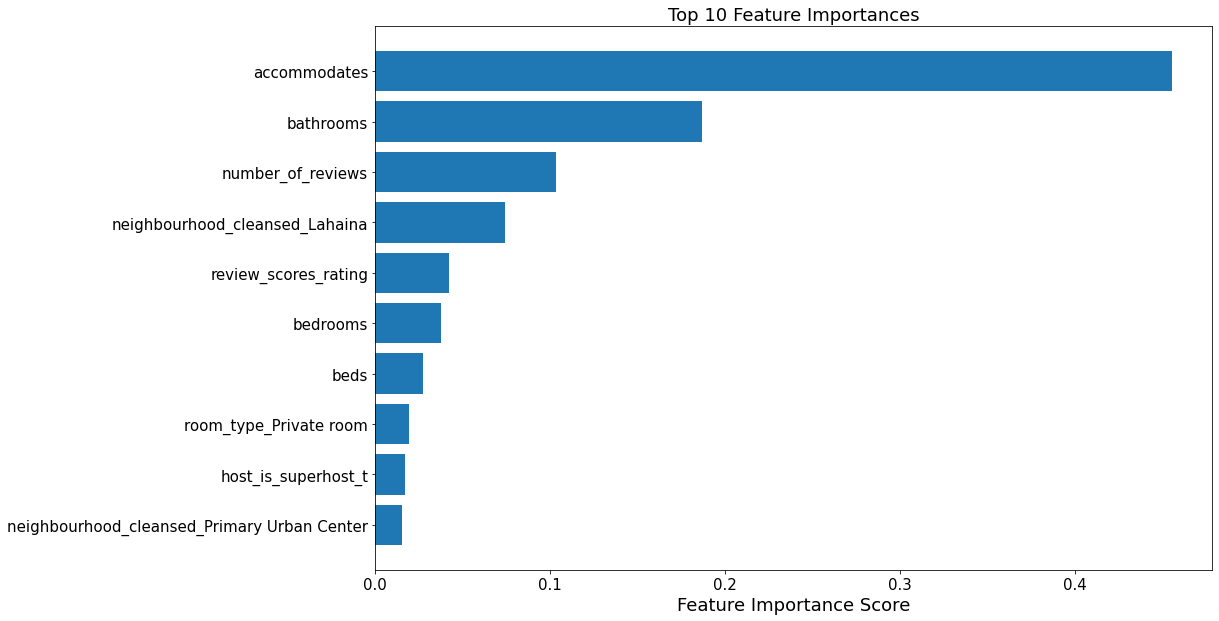

In [31]:
price_model.feature_importance(10)

### Ad-hoc analysis: Top 3 features vs. average price

In [32]:
# define a function for a scatter plot with the chosen feature and average price

def plot_feature_avg_price(feature, color, x_label, title):
    ''' Draw a scatter plot with the chosen feature and average price
    Args:
    feature - string. column name of the feature to plot
    color - string. color of the dots in the plot
    x_label - string. x-label of the plot
    title - string. title of the plot

    Returns:
    scatter plot
    '''
    # define the average price per accommodates
    accomm_avg_price = df_listing_clean.groupby(feature)['price'].mean()

    # scatter plot
    plt.scatter(x = accomm_avg_price.index, y = accomm_avg_price, c=color)
    plt.xlabel(x_label)
    plt.ylabel('Mean price ($)')
    plt.title(title)
    plt.show();

#### 1. Accommodates (Max. capacity)

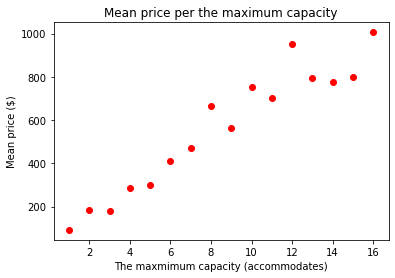

In [33]:
plot_feature_avg_price('accommodates', 'red', 'The maxmimum capacity (accommodates)', 'Mean price per the maximum capacity')

#### 2. Number of bathrooms

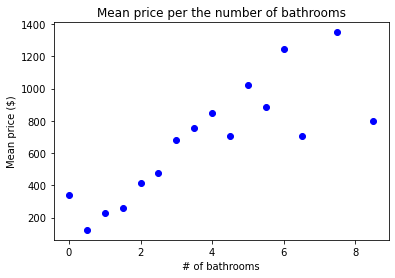

In [34]:
plot_feature_avg_price('bathrooms', 'blue', '# of bathrooms', 'Mean price per the number of bathrooms')

#### 3. Number of reviews

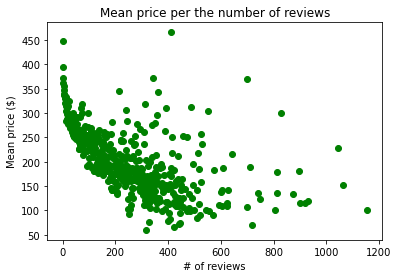

In [35]:
plot_feature_avg_price('number_of_reviews', 'green', '# of reviews', 'Mean price per the number of reviews')